In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, \
                              get_system_from_template, \
                              get_arch_from_template, \
                              get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot, imshow_pairplot, get_log_q_z_mesh
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA
from dsn.util.dsn_util import load_DSNs

import os

In [2]:
os.chdir('../../')

In [3]:
# model/behavior specs
sysname = "V1Circuit"
dirstr = 'V1Circuit'
alphas = ['E','P','S','V']
behavior_type = "difference"
inc_val = 0.1

# optimization hyperparameters
c_init_ords = np.array([5])
start_rs = 1
num_rs = 5
random_seeds = np.arange(start_rs, start_rs+num_rs)

# architecture specification
repeats = 1
nlayers = 2
upl = 10

# convergence criteria
alpha=0.05
frac_samps=0.5
tol = 0.001*np.ones((1,))
tol_inds = [1]

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol':tol,
    'tol_inds':tol_inds
}


num_alphas = len(alphas)

In [4]:
best_models = []
ME_its = []
param_dicts = []
systems = []

# Grab the ME models
for i in range(num_alphas):
    alpha = alphas[i]
    param_dict = {'behavior_type':behavior_type,
                 "alpha":alpha,
                 "inc_val":inc_val}
    system = get_system_from_template(sysname, param_dict)

    arch_params = {
                   'D':system.D,
                   'repeats':repeats,
                   'nlayers':nlayers,
                   'upl':upl,
                  }
    param_dict.update(arch_params)
    arch_dict = get_arch_from_template(system, param_dict)
    
    best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                       random_seeds, dirstr, conv_dict)
    best_models.append(best_model)
    ME_its.append(ME_it)
    param_dicts.append(param_dict)
    systems.append(system)
    
sessions, tf_vars, feed_dicts = load_DSNs(best_models, ME_its)

no file models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_E_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=5/opt_info.npz
no file models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_P_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=5/opt_info.npz
no file models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_S_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=5/opt_info.npz
no file models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_V_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=5/opt_info.npz
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_E_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=3/model-2
Loaded DGM in 1.82 seconds
here 1
INFO:tensorflow:Restoring parameters from models/V1Circuit/V1Circuit_h_RUNE_h_RUNP_h_RUNS_h_RUNV_P_diff_1.00E-01_1.00E-04_flow=1R_4M_2L_10U_M_A_c=5_rs=2/model-2
here 1
INFO:tensorflow:Restor

In [5]:
def calculate_M(W, b, r_ss):
    F = 2*np.diag(np.sqrt(r_ss[:,0]))
    M_inv = np.linalg.inv(F) - W
    M = np.linalg.inv(M_inv)
    return M, M_inv

for i in range(1):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    
    W_tf, b_tf, h_FF_tf, h_LAT_tf, h_RUN_tf, tau_tf, n_tf, s_0_tf, a_tf, c_50_tf = system.filter_Z(Z)
    r_t_tf = system.simulate(Z)
    with tf.Session() as sess:
        W, b, r_t = sess.run([W_tf, b_tf, r_t_tf], {Z:np.zeros((1,1,system.D))})
    W = W[0,0]
    b = b[0,0]
    r_ss = r_t[-1,0,0]

    M, M_inv = calculate_M(W, b, r_ss)
    drdh = M
    dhdr = M_inv

dh_mins = []
dh_maxs = []
dh_eps = 1e-3
for i in range(num_alphas):
    r_min = np.zeros((system.D))
    r_max = np.zeros((system.D))
    r_min[i] = param_dict["inc_val"] - 0.02
    r_max[i] = param_dict["inc_val"] + 0.02
    dh_min = np.matmul(dhdr, r_min) - dh_eps
    dh_max = np.matmul(dhdr, r_max) + dh_eps
    dh_mins.append(dh_min)
    dh_maxs.append(dh_max)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
pfnames = []
cbar_fnames = []
distribution_labels = []
for i in range(num_alphas):
    alpha = alphas[i]
    pfnames.append('../written/NN2019/figures/fig2/DSN_h_dr%s=%.1f.png' % (alpha, inc_val))
    cbar_fnames.append('../written/NN2019/figures/fig2/colorbar_dr%s=%.1f.png' % (alpha, inc_val))
    distribution_labels.append(r'$q_\theta(dh \mid B(%s, %.1f))$' % (alphas[i], inc_val))
    
cmap_labels = ['Greys', 'Blues', 'Reds', 'Greens']
cmaps = []
for i in range(len(cmap_labels)):
    cmaps.append(plt.get_cmap(cmap_labels[i]))
    
lb, ub = system.density_network_bounds

system.z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']

In [7]:
"""from matplotlib.colors import ListedColormap, LinearSegmentedColormap
black = [255,255,255]
blue = [75,105,160]
colors = [black, blue]

denom = 256.0
for i in range(len(colors)):
    color = colors[i]
    cdict = {'red':   [[0.0,  0.0, 0.0],
                       [color[0]/denom,  color[0]/denom, color[0]/denom]],
             'green': [[0.0,  0.0, 0.0],
                       [color[1]/denom,  color[1]/denom, color[1]/denom]],
             'blue':  [[0.0,  0.0, 0.0],
                       [color[2]/denom,  color[2]/denom, color[2]/denom]]}

    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    cmaps[i] = newcmp"""

"from matplotlib.colors import ListedColormap, LinearSegmentedColormap\nblack = [255,255,255]\nblue = [75,105,160]\ncolors = [black, blue]\n\ndenom = 256.0\nfor i in range(len(colors)):\n    color = colors[i]\n    cdict = {'red':   [[0.0,  0.0, 0.0],\n                       [color[0]/denom,  color[0]/denom, color[0]/denom]],\n             'green': [[0.0,  0.0, 0.0],\n                       [color[1]/denom,  color[1]/denom, color[1]/denom]],\n             'blue':  [[0.0,  0.0, 0.0],\n                       [color[2]/denom,  color[2]/denom, color[2]/denom]]}\n\n    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)\n    cmaps[i] = newcmp"

ticks [-4, -2, 0, 2, 4]
0
dist (300, 4)
saving figure to  ../written/NN2019/figures/fig2/DSN_h_drE=0.1.png
1
dist (300, 4)
saving figure to  ../written/NN2019/figures/fig2/DSN_h_drP=0.1.png
2
dist (300, 4)
saving figure to  ../written/NN2019/figures/fig2/DSN_h_drS=0.1.png
3
dist (300, 4)
saving figure to  ../written/NN2019/figures/fig2/DSN_h_drV=0.1.png


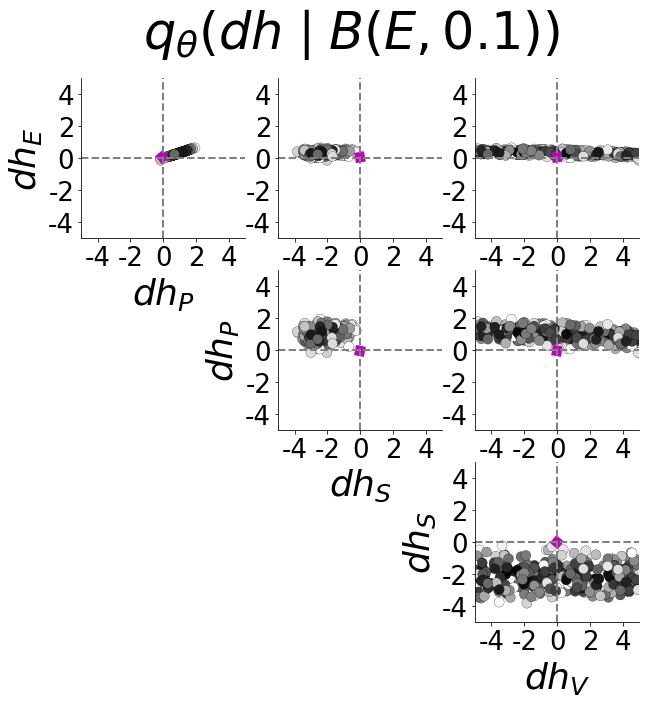

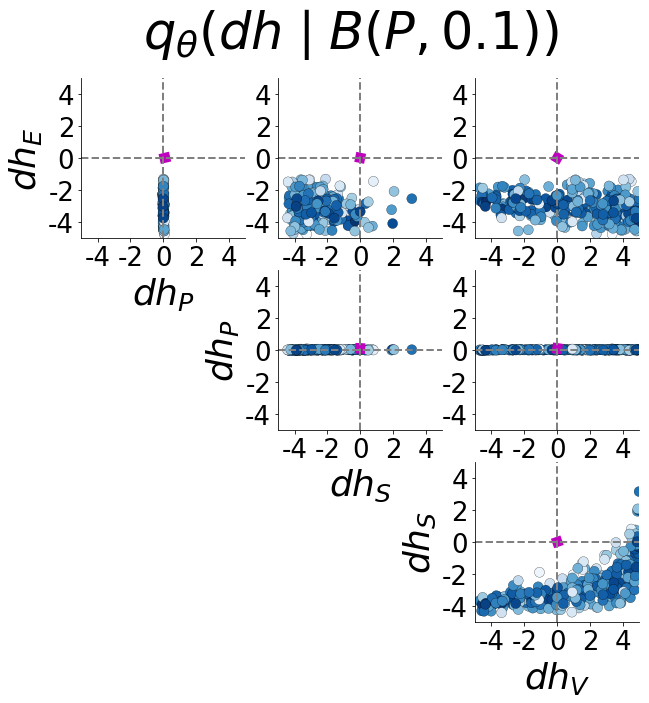

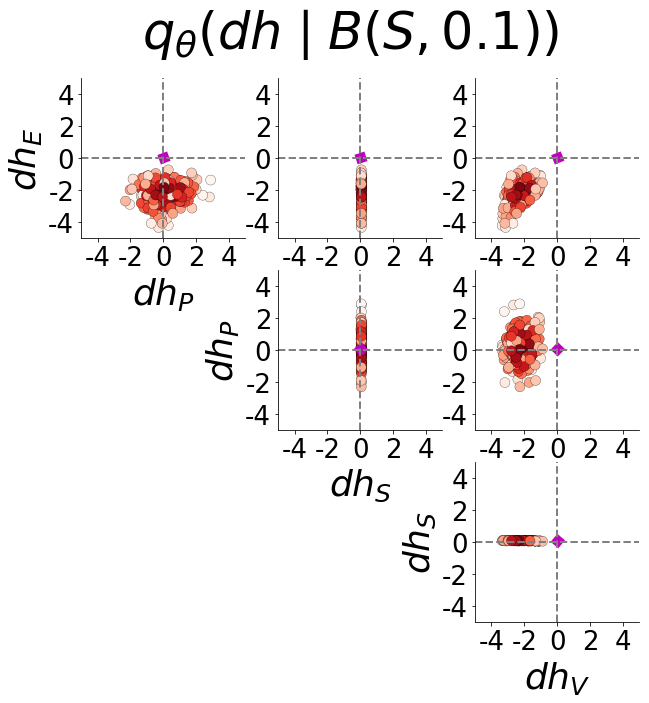

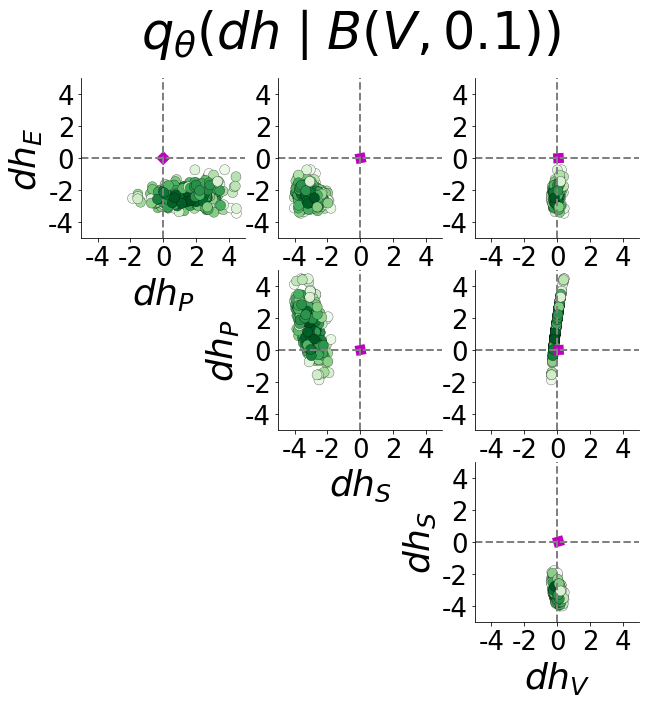

In [7]:
dists, cs, axs = dsn_pairplots(best_models, 'Zs', system, ME_its, \
                      c_str='log_q_z', cmaps=cmaps, legendstrs=distribution_labels, \
                      ticks = [-4, -2, 0, 2, 4], \
                      xlims=[-5,5], ylims=[-5,5], \
                      fontsize=36, ellipses=False, tri=True, \
                      line_mins=dh_mins, line_maxs=dh_maxs, \
                      pfnames=pfnames, \
                      figsize=(10,10))

In [8]:
print(dists[0].shape)

(300, 4)


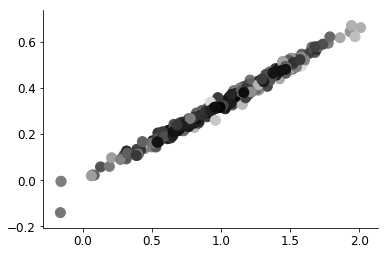

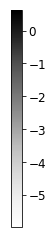

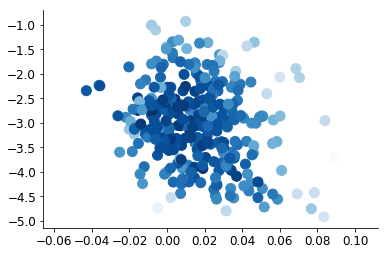

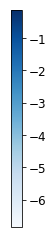

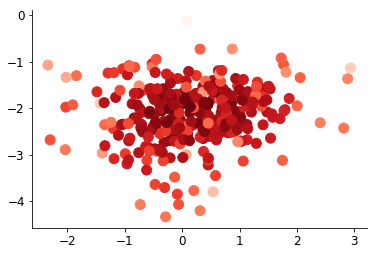

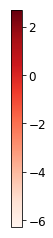

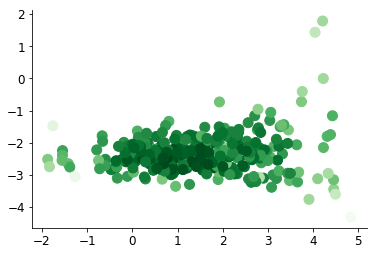

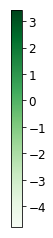

In [9]:
# get colorbars
from dsn.util.plot_util import filter_outliers

for i in range(num_alphas):
    dist = dists[i]
    c = cs[i]
    plot_inds, below_inds, over_inds = filter_outliers(c, 10)
    plt.figure()
    h = plt.scatter(dist[plot_inds,1], dist[plot_inds,0], c=c, cmap=cmaps[i])
    fig,ax = plt.subplots()
    plt.colorbar(h,ax=ax)
    ax.remove()
    plt.savefig(cbar_fnames[i], transparent=True)
    plt.show()

In [10]:
print('line maxs')
print(dh_maxs)
print('line mins')
print(dh_mins)

line maxs
[array([ 0.0701831, -0.069626 , -0.0177824, -0.015506 ]), array([0.0246736, 0.1180426, 0.001    , 0.011824 ]), array([0.0167728 , 0.05242   , 0.05976576, 0.049048  ]), array([0.001     , 0.001     , 0.025     , 0.09813645])]
line mins
[array([ 0.04512207, -0.048084  , -0.0135216 , -0.012004  ]), array([ 0.0147824,  0.0770284, -0.001    ,  0.006216 ]), array([0.0095152 , 0.03328   , 0.03817718, 0.031032  ]), array([-0.001     , -0.001     ,  0.015     ,  0.06375763])]


In [11]:
print(system.mu)

[0.1    0.0001]


In [12]:
h_vals = np.array([0.1, 0.5])
num_hs = len(h_vals)
h_mat = np.expand_dims(h_vals, 1) * np.ones((1,system.D))
for i in range(1):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    
    r_t_tf = system.simulate(Z)
    _Z = np.expand_dims(h_mat, 0)
    with tf.Session() as sess:
        _r_t = sess.run(r_t_tf, {Z:_Z})
    print(_r_t.shape)


(100, 2, 2, 4, 1)


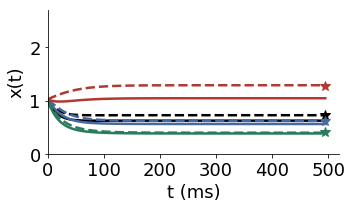

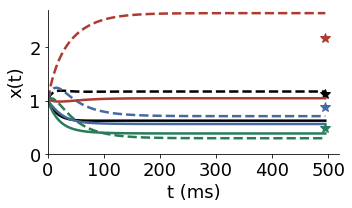

In [13]:
fontsize = 18
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]
lw = 2.5
figsize = (5, 3)
t_ticks = [0, 100, 200, 300, 400, 500]

r_ss = _r_t[-1,0,i,:,0]
for i in range(num_hs):
    t = 1000*system.dt*np.arange(system.T)
    h_i = h_vals[i]*np.ones((system.D,1))
    dr = np.dot(drdh, h_i)
    plt.figure(figsize=figsize)
    for j in range(system.D):
        plt.plot(t, _r_t[:,0,i,j,0], '-', lw=lw, c=colors[j])
        plt.plot(t, _r_t[:,1,i,j,0], '--', lw=lw, c=colors[j])
        plt.plot(t[-1], r_ss[j]+dr[j], '*', lw=lw, c=colors[j])
    plt.xlim([0, 520])
    plt.ylim([0, 2.7])
    plt.xlabel('t (ms)', fontsize=fontsize)
    plt.ylabel('x(t)', fontsize=fontsize)
    plt.xticks(t_ticks, fontsize=fontsize)
    plt.yticks(np.arange(0, 2.1, 1.0), fontsize=fontsize)
    
    plt.tight_layout()
    plt.savefig('../written/NN2019/figures/fig2/lin_pred_hval=%.1f.pdf' % h_vals[i])
    plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

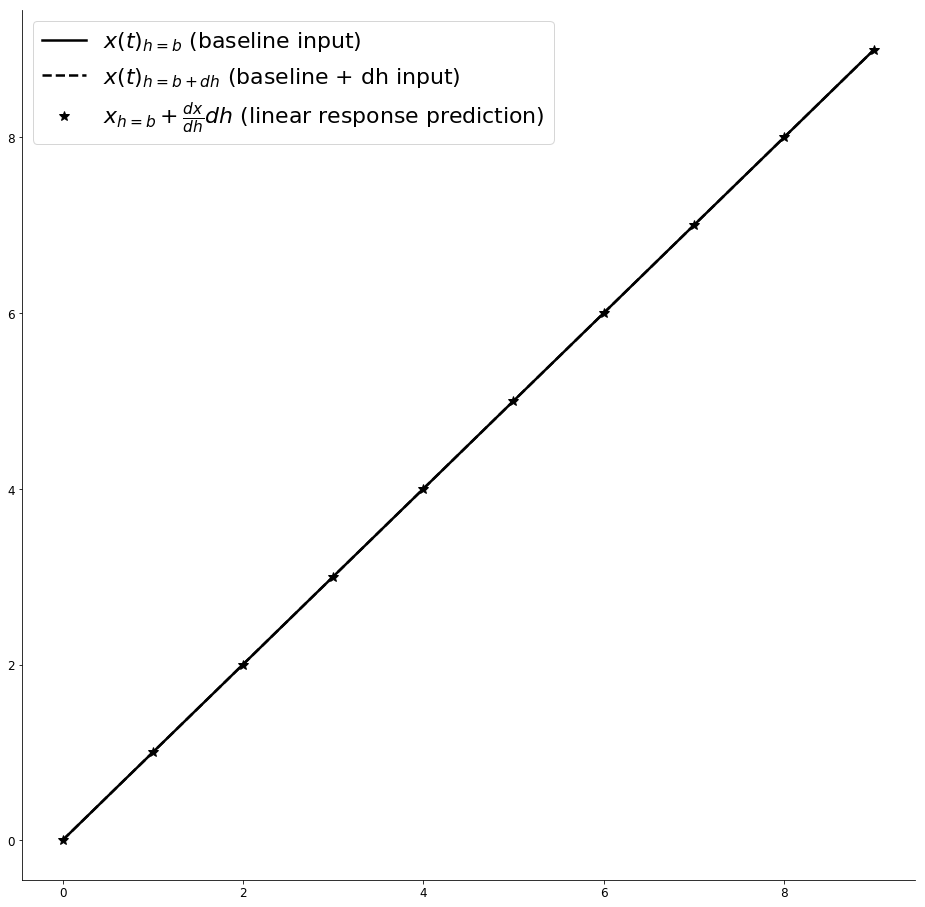

In [14]:
dummy = np.arange(10)
plt.figure(figsize=(16,16))
plt.plot(dummy, dummy, 'k-', lw=lw)
plt.plot(dummy, dummy, 'k--', lw=lw)
plt.plot(dummy, dummy, 'k*')
legendstrs = [r'$x(t)_{h=b}$ (baseline input)', r'$x(t)_{h=b+dh}$ (baseline + dh input)', r'$x_{h=b} + \frac{dx}{dh}dh$ (linear response prediction)']
plt.legend(legendstrs, fontsize=fontsize+4)
plt.show

-26.572352960352134
-178.50893135052397
-45.45773935257792
-302.42403115293683
-84.32223672076057
-285.9872796873997
dh_min [ 0.04612207 -0.047084   -0.0125216  -0.011004  ]
dh_max [ 0.0691831 -0.070626  -0.0187824 -0.016506 ]


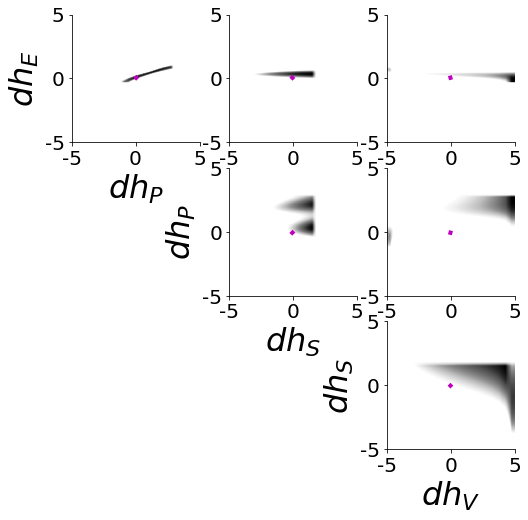

In [15]:
cmap_labels = ['Greys', 'Blues', 'Reds', 'Greens']
cmaps = []
for i in range(len(cmap_labels)):
    cmaps.append(plt.get_cmap(cmap_labels[i]))
    
lb, ub = system.density_network_bounds

z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']

alpha_val = 1.0
buf = 1e-2
K = 20
M = K**system.D
M_samp = 1000
fontsize = 24
ext_fac = 0.2
    

fig = None
axs = None
for i in range(1):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    system = systems[i]
    lb, ub = system.density_network_bounds
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    cmap = cmaps[i]
    alpha = alphas[i]
    
    r_min = np.zeros((system.D))
    r_max = np.zeros((system.D))
    r_min[i] = param_dict["inc_val"] - 0.02
    r_max[i] = param_dict["inc_val"] + 0.02
    dh_min = np.matmul(dhdr, r_min)
    dh_max = np.matmul(dhdr, r_max)
    
    _W = np.random.normal(0.0, 1.0, (1,M_samp,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z_samp = sess.run(Z, feed_dict)
    
    min_samp = np.min(_Z_samp[0], 0)
    max_samp = np.max(_Z_samp[0], 0)
    interval_samp = max_samp - min_samp
    a_grid = np.zeros((system.D))
    b_grid = np.zeros((system.D))
    for j in range(system.D):
        a_grid[j] = max(min_samp[j] - ext_fac*interval_samp[j], lb[j]+buf)
        b_grid[j] = min(max_samp[j] + ext_fac*interval_samp[j], ub[j]-buf)
    
    Z_grids = np.meshgrid(np.linspace(a_grid[0], b_grid[0], K),
                          np.linspace(a_grid[1], b_grid[1], K),
                          np.linspace(a_grid[2], b_grid[2], K),
                          np.linspace(a_grid[3], b_grid[3], K), indexing='ij')
                         
    _Z_grid = np.zeros((1,M,system.D))
    for i in range(system.D):
        _Z_grid[0,:,i] = np.reshape(Z_grids[i], (M,))
        
    log_q_z_mesh = get_log_q_z_mesh(_Z_grid, W, Z_input, Z_INV, log_q_Z, sess, feed_dict, K)
    
    fig, axs = imshow_pairplot(log_q_z_mesh, range(4), z_labels,
                               lb=lb, ub=ub, a=a_grid, b=b_grid, fontsize=fontsize+8,
                               figsize=(8,8), cmap=cmap, alpha=alpha_val, q=75,
                               fig=None, axs=None)
    print('dh_min', dh_min)
    print('dh_max', dh_max)
    for i in range(system.D-1):
        for j in range(i,system.D-1):
            axs[i,j].plot([dh_min[j],dh_max[j]],[dh_min[i],dh_max[i]],'m-', lw=4)
            axs[i,j].set_xticks([-5,0,5])
            axs[i,j].set_xticklabels([-5,0,5], fontsize=fontsize-4)
            axs[i,j].set_yticks([-5,0,5])
            axs[i,j].set_yticklabels([-5,0,5], fontsize=fontsize-4)
            
    #plt.savefig('../written/NN2019/figures/fig2/DSN_h_dr%s=%.1f.png' % (alpha, inc_val))
    
    plt.show()

### Get neuron-type responses to specific populations

delta xE delta hE beta 1.621495086599202 pvalue 2.971967613098576e-31
monotonic
delta xE delta hV beta 0.0 pvalue 1.0
monotonic


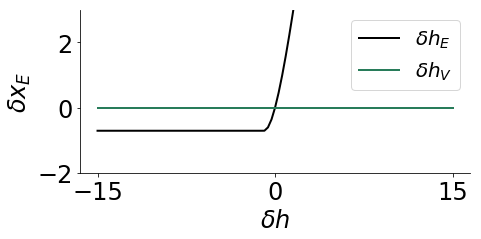

delta xP delta hE beta 1.2112964443439942 pvalue 1.3319754575273866e-25
monotonic
delta xP delta hP beta 1.062791872069409 pvalue 1.6400047722075934e-34
monotonic
delta xP delta hV beta 0.0 pvalue 1.0
monotonic


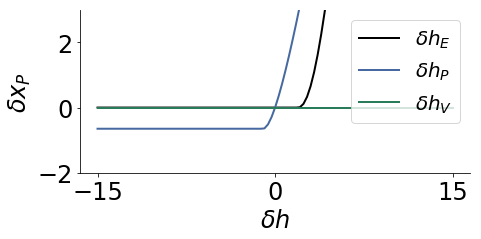

delta xS delta hE beta 1.7875189491346375 pvalue 2.760209285758928e-20
monotonic
delta xS delta hP beta 0.0 pvalue 1.0
monotonic
delta xS delta hS beta 6.802819822809861 pvalue 2.652789609220591e-26
monotonic


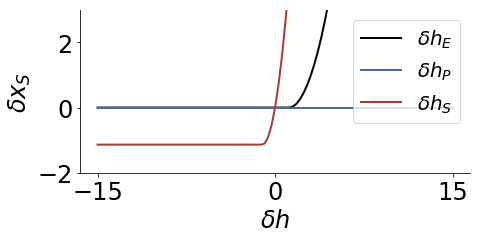

delta xV delta hE beta 0.002215491262249899 pvalue 0.5062255031485505
delta xV delta hV beta 6.407132457928288 pvalue 1.3649782284872574e-25
monotonic


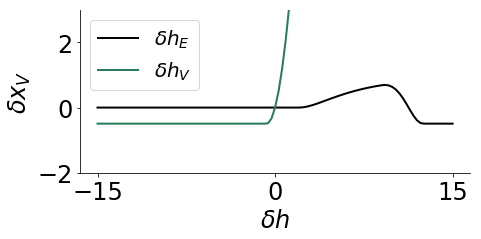

In [23]:
M = 101
M_samp = 200
yticks = [-2, 0, 2]
ylims = [-2, 3]
dh_ls = [15,15,15,15]
neuron_labels = ['E', 'P', 'S', 'V']
r_labels = [r'$x_{E,ss}$', '$x_{P,ss}$', '$x_{S,ss}$', '$x_{V,ss}$']

neuron_inds = [0, 1, 2, 3]
input_inds_list = [[0, 3], 
                   [0, 1, 3],
                   [0, 1, 2],
                   [0, 3]]

input_labels_list = [[r'$\delta h_E$', r'$\delta h_V$'],
                     [r'$\delta h_E$', r'$\delta h_P$', r'$\delta h_V$'],
                     [r'$\delta h_E$', r'$\delta h_P$', r'$\delta h_S$'],
                     [r'$\delta h_E$', r'$\delta h_V$']]

for i in range(num_alphas):
    dh_l = dh_ls[i]
    xticks = [-dh_l, 0, dh_l]
    neuron_ind = neuron_inds[i]
    input_inds = input_inds_list[i]
    input_labels = input_labels_list[i]
    sess = sessions[neuron_ind]
    tf_var = tf_vars[neuron_ind]
    feed_dict = feed_dicts[neuron_ind]
    system = systems[neuron_ind]
    lb, ub = system.density_network_bounds
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    cmap = cmaps[neuron_ind]
    alpha = alphas[neuron_ind]

    T_x = system.compute_suff_stats(Z)

    _W = np.random.normal(0.0, 1.0, (1,M_samp,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z_samp, _log_q_Z = sess.run([Z, log_q_Z], feed_dict)


    max_ind = np.argmax(_log_q_Z[0])
    z_max = _Z_samp[:,max_ind,:]

    plt.figure(figsize=(7,3))
    x = np.linspace(-dh_l, dh_l, M)
    for j in input_inds:
        _Z = np.zeros((1,M,system.D))
        for k in range(system.D):
            if (j==k):
                dh_vals = np.linspace(z_max[0,k]-dh_l, z_max[0,k]+dh_l, M)
                _Z[0,:,k] = dh_vals
            else:
                _Z[0,:,k] = z_max[0,k]*np.ones((M,))
        _T_x = sess.run(T_x, {Z:_Z})
        # make a \Delta (M//2) is \Delta h = 0.  Make ref wrt dh*
        Delta_h = _T_x[0,:,0] - _T_x[0,M//2,0]
        plt.plot(x, Delta_h, c=colors[j], lw=2)
        plt.legend(input_labels, fontsize=(fontsize-4))
        
        beta, offset, r, p, stderr = scipy.stats.linregress(x, Delta_h)
        print('delta x%s' % neuron_labels[i], 
              'delta h%s' % neuron_labels[j], 
              'beta', beta, 'pvalue', p)
        if (np.sum(np.diff(Delta_h) >= 0) == (Delta_h.shape[0]-1)):
            print('monotonic')
    plt.ylim(ylims)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    plt.xlabel('$\delta h$', fontsize=fontsize)
    plt.ylabel(r'$\delta x_{%s}$' % neuron_labels[neuron_ind], fontsize=(fontsize))
    plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

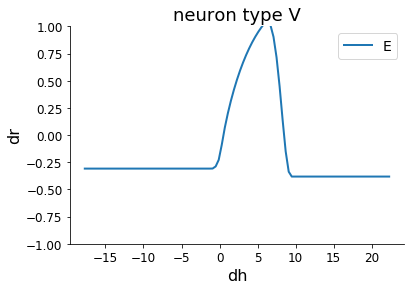

In [18]:
M = 101
dh_l = 20

neuron_ind = 3

sess = sessions[neuron_ind]
tf_var = tf_vars[neuron_ind]
feed_dict = feed_dicts[neuron_ind]
system = systems[neuron_ind]
lb, ub = system.density_network_bounds
W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
cmap = cmaps[neuron_ind]
alpha = alphas[neuron_ind]
    
T_x = system.compute_suff_stats(Z)
r_t = system.simulate(Z)

_W = np.random.normal(0.0, 1.0, (1,M_samp,system.D))
_Z_input_dummy = np.zeros((1,1,system.D))
feed_dict.update({W:_W, Z_input:_Z_input_dummy})
_Z_samp, _log_q_Z, _r_t = sess.run([Z, log_q_Z, r_t], feed_dict)

r_ss = _r_t[-1,1,:,:,0]

max_ind = np.argmax(_log_q_Z[0])
z_max = _Z_samp[:,max_ind,:]



# Figure out repoonses to perturbations away from mode for each neuron type
plt.figure()
j = 0
_Z = np.zeros((1,M,system.D))
for k in range(system.D):
    if (j==k):
        dh_vals = np.linspace(z_max[0,k]-dh_l, z_max[0,k]+dh_l, M)
        _Z[0,:,k] = dh_vals
    else:
        _Z[0,:,k] = z_max[0,k]*np.ones((M,))
_T_x = sess.run(T_x, {Z:_Z})
plt.plot(dh_vals, _T_x[0,:,0])
plt.xlabel('dh')
plt.ylabel('dr')
plt.legend(neuron_labels)
plt.title('neuron type %s' % alpha)
plt.ylim([-1, 1])
plt.show